## Medical Image Segmentation - Standard U-NET implementation

In [1]:
%load_ext autoreload
%autoreload 2

#### Import modules

In [3]:
import sys
from pathlib import Path
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import sklearn as sk

plt.style.use('dark_background')

#### Local imports

In [4]:
sys.path.append(str(Path(".").resolve().parent))

from scripts.experiments import InputOutput
io = InputOutput()

### Step 1 - Loading training data

In [5]:
dwi_sequence, dwi_segmentation = io.read_nrrds("../MRI_data/ROI/DWI/exvivo")
sequence_header, sequence_vol = io.nrrd_to_matrix(dwi_sequence)
segmentation_header, segmentation_vol = io.nrrd_to_matrix(dwi_segmentation)

#### Pre-processing data
`[TO-DO] - Build the volume fixer into the InputOutput module`

In [6]:
def fix_volume_shape(volume):
    """
    This module fixes the shape of a volume if there is a transposed image.
    Sometimes this happens for the DWI sequence.
    """
    if volume.shape[0] == 128 and volume.shape[1] == 104:
        volume = np.transpose(volume, (1, 0, 2))
    return volume

sequence_vol = [fix_volume_shape(vol) for vol in sequence_vol]
segmentation_vol = [fix_volume_shape(vol) for vol in segmentation_vol]

#### Save image volumes to an array of images

In [7]:
sequence_vol = np.concatenate(sequence_vol, axis=2)
segmentation_vol = np.concatenate(segmentation_vol, axis=2)
sequence_vol.shape, segmentation_vol.shape

((104, 128, 570), (104, 128, 570))

#### Image normalization
Succesfully training u-nets requires the image data to be standardized. The raw sequences produced by the MRI scanner contain extreme values which do not make sense to preserve in the scope of object detection. The graph below identifies there are rare extreme outliers in the complete dataset. I will clip at the 5th diviation from the mean, perserving 99.999% of the data.

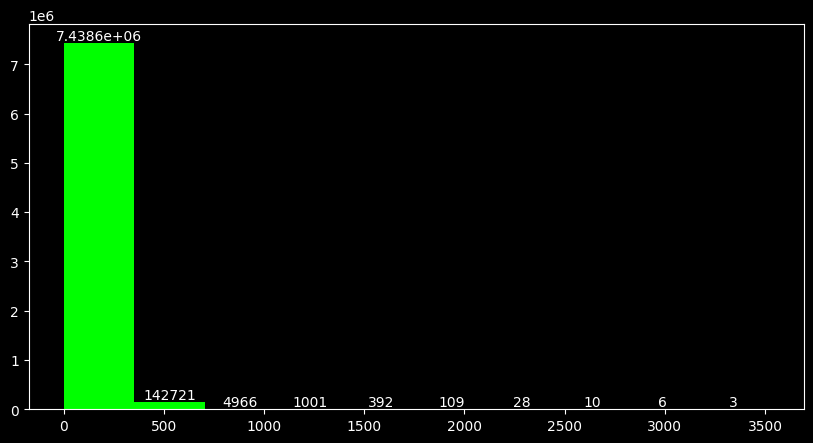

In [8]:
plt.figure(figsize=(10,5))
counts, edges, bars = plt.hist(sequence_vol.flatten(), color="lime")
plt.bar_label(bars, label_type='edge')
plt.show()

In [9]:
avg = sequence_vol.mean()
std = np.std(sequence_vol)
upper = avg + 5 * std
avg, std, upper

(np.float64(47.61885648616734),
 np.float64(99.9262144293089),
 np.float64(547.2499286327119))

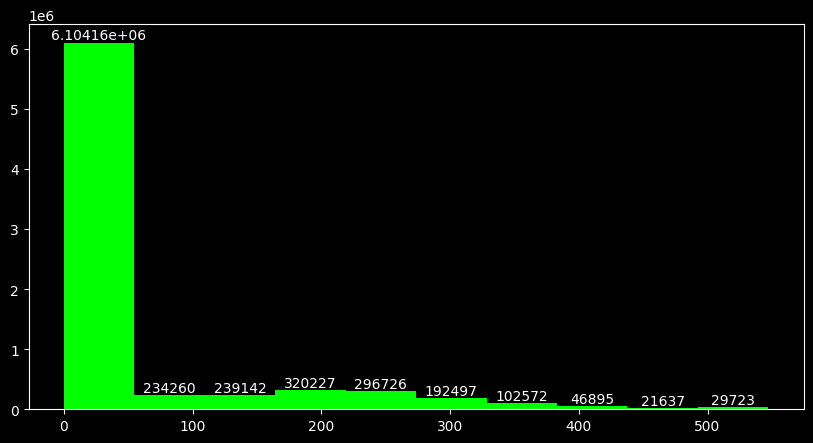

In [10]:
plt.figure(figsize=(10,5))
clipped_sequence_vol = np.clip(sequence_vol, a_min=0, a_max=upper)
counts, edges, bars = plt.hist(clipped_sequence_vol.flatten(), color="lime")
plt.bar_label(bars, label_type='edge')
plt.show()

In [11]:
sequence_vol_n = clipped_sequence_vol / clipped_sequence_vol.max()
sequence_vol.min(), sequence_vol.max(), sequence_vol_n.min(), sequence_vol_n.max()

(np.uint16(0), np.uint16(3517), np.float64(0.0), np.float64(1.0))

#### Sanity check for segmentation  
Our segmentation volume is supposed to have only two classes; either renal cortex `1` or not renal-cortex `0`. The code snippet below simply returns all unique values, this confirms there are only two values with a maximum of `1`.

In [12]:
np.unique(segmentation_vol)

array([0, 1], dtype=uint8)

#### Reshaping the data
It is paramount for standard u-nets to have square images having a image size in powers of two. The data we're working with is in an odd size `(104, 128)`. To combat this the image will be cropped from the sides to form an image which is `(96, 96)`.

In [13]:
sequence_vol_n.shape, segmentation_vol.shape

((104, 128, 570), (104, 128, 570))

In [15]:
def crop_to_size(seqs, segs, x, y):
    return seqs[0:x,0:y,:], segs[0:x,0:y,:]

sequence_vol, segmentation_vol = crop_to_size(sequence_vol, segmentation_vol, x=96, y=128)

In [19]:
# sequence_vol = tf.image.crop_to_bounding_box(
#     sequence_vol_n,
#     offset_height=4,
#     offset_width=16,
#     target_height=128,
#     target_width=96
# ).numpy()

# segmentation_vol = tf.image.crop_to_bounding_box(
#     segmentation_vol,
#     offset_height=4,
#     offset_width=16,
#     target_height=128,
#     target_width=96
# ).numpy()

sequence_vol.shape, segmentation_vol.shape

((96, 128, 570), (96, 128, 570))

#### Cropped segmentation and image
After cropping the image to the closest working set of pixels, we can observe that the image is both square and and the segmentation is still fitting.

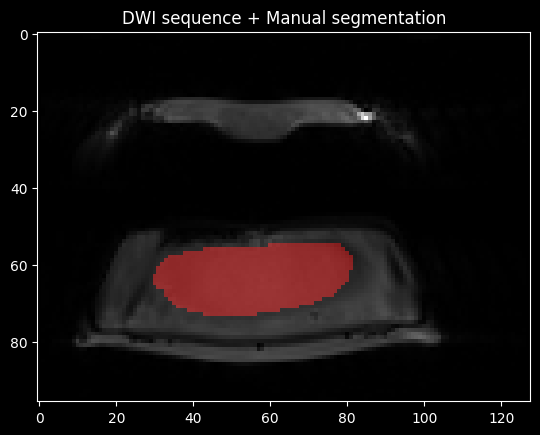

In [17]:
slc = 12
vs = segmentation_vol[...,slc]
v = sequence_vol[...,slc]
v = v / v.max()

rgb = np.stack((v+vs*0.4, v, v), axis=-1)
plt.imshow(rgb)
plt.title("DWI sequence + Manual segmentation")
plt.show()

In [20]:
def convert_to_tensor(seqs, segs):
    # seqs = np.concatenate(seqs, axis=2)
    # segs = np.concatenate(segs, axis=2)
    seqs = seqs.transpose((2, 0, 1))
    segs = segs.transpose((2, 0, 1))
    seqs, segs = np.expand_dims(seqs, axis=-1), np.expand_dims(segs, axis=-1)
    return seqs, segs

sequence_vol, segmentation_vol = convert_to_tensor(sequence_vol, segmentation_vol)

In [22]:
def train_test_validation(volume):
    pct_80 = int(volume.shape[0] // 100 * 80)
    pct_90 = int((volume.shape[0] // 100 * 90))
    pct_100 = int(volume.shape[0])
    return volume[0:pct_80], volume[pct_80: pct_90], volume[pct_90:pct_100]

seg_train, seg_test, seg_val = train_test_validation(segmentation_vol)
seq_train, seq_test, seq_val = train_test_validation(sequence_vol)
dwi_data = {"seg_test": seg_test,
            "seq_test": seq_test,
            "seg_train": seg_train,
            "seq_train": seq_train,
            "seg_val": seg_val,
            "seq_val": seq_val}

#### Creating a Train- / Test- / Validation-set
For this particular example, the amount of samples when split in a 80 : 10 : 10 manner does not produce a remainder. These fractions will be the 80% training set and 10% test and validation set.

In [ ]:
print(segmentation_vol.shape)

def train_test_validation(volume):
    pct_80 = int(volume.shape[2] // 100 * 80)
    pct_90 = int((volume.shape[2] // 100 * 90))
    pct_100 = int(volume.shape[2])
    return volume[...,0:pct_80], volume[...,pct_80: pct_90], volume[...,pct_90:pct_100]

seg_train, seg_test, seg_val = train_test_validation(segmentation_vol)
seq_train, seq_test, seq_val = train_test_validation(sequence_vol)
seg_train.shape, seg_test.shape, seg_val.shape

(96, 96, 570)


((96, 96, 456), (96, 96, 57), (96, 96, 57))

In [17]:
# For training masks
seq_train = np.transpose(seq_train, (2, 0, 1))
seq_train = np.expand_dims(seq_train, axis=-1)

# For validation masks
seq_test = np.transpose(seq_test, (2, 0, 1))
seq_test = np.expand_dims(seq_test, axis=-1)

# For validation masks
seq_val = np.transpose(seq_val, (2, 0, 1))
seq_val = np.expand_dims(seq_val, axis=-1)

In [18]:
# For training masks
seg_train = np.transpose(seg_train, (2, 0, 1))
seg_train = np.expand_dims(seg_train, axis=-1)

# For validation masks
seg_test = np.transpose(seg_test, (2, 0, 1))
seg_test = np.expand_dims(seg_test, axis=-1)

# For validation masks
seg_val = np.transpose(seg_val, (2, 0, 1))
seg_val = np.expand_dims(seg_val, axis=-1)

In [19]:
dwi_data = {"seg_test": seg_test,
            "seq_test": seq_test,
            "seg_train": seg_train,
            "seq_train": seq_train,
            "seg_val": seg_val,
            "seq_val": seq_val}

In [23]:
import pickle

with open("DWI_exvivo_data.pkl", mode="b+w") as p_out:
    pickle.dump(dwi_data, p_out)

### Step 2 - Declaring U-net

In [21]:
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from keras.models import Model, Sequential

In [22]:
def convolutional_operaration(input_tensor, filters=64):
    # Convolutional block one
    conv1 = Conv2D(filters, kernel_size=(3,3), padding="same")(input_tensor)
    batch_norm1 = BatchNormalization()(conv1)
    activation1 = ReLU()(batch_norm1)

    # Convolutional block two
    conv2 = Conv2D(filters, kernel_size=(3,3), padding="same")(activation1)
    batch_norm2 = BatchNormalization()(conv2)
    activation2 = ReLU()(batch_norm2)

    return activation2

In [23]:
def encoder(entered_input, filters=64):
    enc = convolutional_operaration(entered_input, filters)
    maxpo = MaxPooling2D(strides=(2,2))(enc)
    return enc, maxpo

In [24]:
def decoder(entered_input, skip, filters=64):
    upsample = Conv2DTranspose(filters, (2,2), strides=2, padding="same")(entered_input)
    connection = Concatenate()([upsample, skip])
    out = convolutional_operaration(connection, filters)
    return out

In [25]:
def U_net(imagesize):

    inputs = Input(imagesize)

    # encoding phase
    skip_1, encoder_1 = encoder(inputs, filters=64)
    skip_2, encoder_2 = encoder(encoder_1, filters=64*2)
    skip_3, encoder_3 = encoder(encoder_2, filters=64*4)
    skip_4, encoder_4 = encoder(encoder_3, filters=64*8)

    # Bottom U
    convolutioal = convolutional_operaration(encoder_4, filters=64*16)

    # decoding phase
    decoder_1 = decoder(convolutioal, skip_4, filters=64*8)
    decoder_2 = decoder(decoder_1, skip_3, filters=64*4)
    decoder_3 = decoder(decoder_2, skip_2, filters=64*2)
    decoder_4 = decoder(decoder_3, skip_1, filters=64)

    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(inputs, out)

    return model

In [26]:
input_shape = (96, 96, 1,)
model = U_net(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 96, 96,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 96, 96,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 96,    │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 96, 96,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 48,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 24,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

#### Dice score as loss function
The dice score compares the the normalized surface of the prediction and the ground truth.  
$s_v=\frac{2|\boldsymbol{a \cdot b}|}{|\boldsymbol{a}|^2 + |\boldsymbol{b}|^2}$

In [27]:
seq_train.shape

(456, 96, 96, 1)

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
            "../models/unet_prototype_1.model.keras",
            monitor="val_loss",
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode="auto",
            save_freq="epoch",
            initial_value_threshold=None,
    )
]

### Step 3 - Training the model
#### Prototype 1

#### Prototype 2

In [33]:
keras.optimizers.RMSprop?

Init signature:
keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    loss_scale_factor=None,
    gradient_accumulation_steps=None,
    name='rmsprop',
    **kwargs,
)
Docstring:     
Optimizer that implements the RMSprop algorithm.

The gist of RMSprop is to:

- Maintain a moving (discounted) average of the square of gradients
- Divide the gradient by the root of this average

This implementation of RMSprop uses plain momentum, not Nesterov momentum.

The centered version additionally maintains a moving average of the
gradients, and uses that average to estimate the variance.

Args:
    learning_rate: A float, a
        `keras.optimizers.schedules.LearningRateSchedule` instance, or
        a callable that takes no arguments and returns the actual value t

In [34]:
input_shape = (96, 96, 1,)
model = U_net(input_shape)

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5) , loss="binary_crossentropy")

In [ ]:
history2 = model.fit(seq_train, seg_train,
                    epochs=15,
                    validation_data=(seq_val, seg_val),
                    callbacks=callbacks
                    )

Epoch 1/15


In [81]:
predictions = model.predict(seq_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step


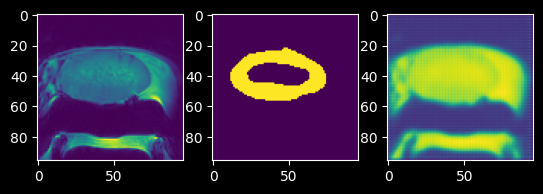

In [95]:
# Plotting
f, axarr = plt.subplots(1, 3)
axarr[0].imshow(seq_test[3])
axarr[1].imshow(seg_test[3])
axarr[2].imshow(predictions[3])
plt.show()

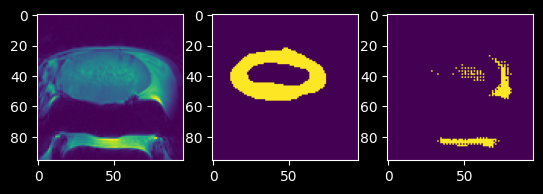

In [109]:
t = predictions[3].max() * .98
above_t = predictions[3] > t
mt = np.zeros_like(predictions[3])
mt[above_t] = 1

# Plotting
f, axarr = plt.subplots(1, 3)
axarr[0].imshow(seq_test[3])
axarr[1].imshow(seg_test[3])
axarr[2].imshow(mt)
plt.show()